# Prepare notebook

In [46]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pyLDAvis
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import string
from wordcloud import WordCloud
from plotting_utilities import *

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/acraig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/acraig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import data

In [3]:
books = pd.read_pickle('2019112_goodreads_book_data.pkl')

In [4]:
len(books)

610

In [5]:
books.goodreads_description.count()

608

In [6]:
categories = pd.read_pickle('2019112_goodreads_book_categories.pkl')

In [7]:
len(categories.columns)

13

# Prepare textual data

In [8]:
alphanumeric_filter = re.compile('[\W_]+')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

books['filtered_description'] = books.goodreads_description.fillna('')\
                                    .map(lambda x: alphanumeric_filter.sub(' ', x).lower().strip())\
                                    .map(lambda text: ' '.join([wnl.lemmatize(token) for token in wpt.tokenize(text) 
                                                                if token not in stop_words]))



In [9]:
books['filtered_doc_length'] = books.filtered_description.map(lambda text: len(text.split(' ')))

 # Visualization

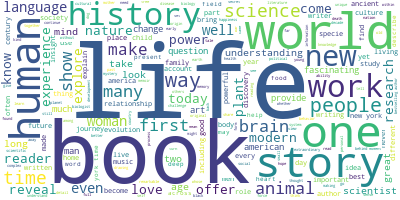

In [10]:
# Generate a word cloud based on all descriptions
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(','.join(list(books.filtered_description.values)))
wordcloud.to_image()

# Word counting methods

In [11]:
max_df=0.90
min_df=4
max_features=2000


### Bag of words

In [12]:
# Fit and transform the descriptions
word_bag_cv = CountVectorizer(ngram_range=(1,1), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
word_bag_counts = word_bag_cv.fit_transform(books.filtered_description)

# Check against visualization
n = 5
counts = word_bag_counts.toarray().sum(axis = 0)
words = word_bag_cv.get_feature_names()
[words[i] for i in np.argpartition(counts, -n)[-n:]] 

['story', 'human', 'book', 'world', 'life']

### Bag of bigrams

In [13]:
# Fit and transform the descriptions
bigram_bag_cv = CountVectorizer(ngram_range=(2,2), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
bigram_bag_counts = bigram_bag_cv .fit_transform(books.filtered_description)

# Check against visualization
n = 5
counts = bigram_bag_counts.toarray().sum(axis = 0)
bigrams = bigram_bag_cv.get_feature_names()
[bigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['award winning', 'year ago', 'bestselling author', 'york time', 'new york']

### Bag of trigrams

In [14]:
# Fit and transform the descriptions
trigram_bag_cv = CountVectorizer(ngram_range=(3,3), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
trigram_bag_counts = trigram_bag_cv.fit_transform(books.filtered_description)

# Check against visualization
n = 5
counts = trigram_bag_counts.toarray().sum(axis = 0)
trigrams = trigram_bag_cv.get_feature_names()
[trigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['york time bestseller',
 'thich nhat hanh',
 'new york time',
 'york time bestselling',
 'time bestselling author']

### TF-IDF 

In [15]:
tfidf_v = TfidfVectorizer(use_idf=True, max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english' )
tfidf_weights = tfidf_v.fit_transform(books.filtered_description)

# Check against visualization
n = 10
weights = tfidf_weights.toarray().sum(axis = 0)
weighted_words = tfidf_v.get_feature_names()
[weighted_words[i] for i in np.argpartition(weights, -n)[-n:]] 

['work',
 'year',
 'time',
 'new',
 'history',
 'human',
 'story',
 'world',
 'book',
 'life']

# Topic Modeling

In [16]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [17]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 20

def print_top_words(model, feature_names, n_top_words = 10):
    for topic_idx, topic in enumerate(model.components_):
        message = " Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [18]:
# Fit the NMF model (Frobenius norm)
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (Frobenius norm):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (Frobenius norm):
 Topic #0: life world book history human new time way story year
 Topic #1: brain neuroscientist memory mind neural recovery mental information principle addiction
 Topic #2: hanh nhat thich peace zen master mindfulness happiness leader spiritual
 Topic #3: language word linguistic knowledge communication linguistics spread linguist use diversity
 Topic #4: introduction short series subject topic analysis oxford area pocket readable
 Topic #5: animal human specie communication intelligence emotion insect elephant autistic mind
 Topic #6: woman men gender letter bad male power business young essay
 Topic #7: bird isabella egg lady indian home travel settlement america adventure
 Topic #8: plant human evolution flower specie insect earth climate color behaviour
 Topic #9: black american america slave slavery white racial obama civil african
 Topic #10: music musical sound theory cd song love listen taste culture
 Topic #11: di la il che della non co

In [19]:
# Fit the NMF model (generalized Kullback-Leibler divergence)
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (generalized Kullback-Leibler divergence):
 Topic #0: world history new human century science modern time age year
 Topic #1: brain human science evolution scientific research question body biology cognitive
 Topic #2: life story time family people experience year day home personal
 Topic #3: book ancient language history art english literature new century culture
 Topic #4: life book author world introduction area offer combine good expert
 Topic #5: animal human way deep language story mean place creature decade
 Topic #6: woman considered gender ago form male explanation prehistoric unique politics
 Topic #7: account bird story adventure british long coast mountain man men
 Topic #8: book beauty reader life plant lover love relationship favorite early
 Topic #9: black american new white america began memoir race time man
 Topic #10: come music di human history today il biology birth musical
 Topic #11: world come good change argues thing great beginning message 

In [20]:
# Fit LDA model 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(word_bag_counts)
print("\nTopics in LDA model:")
print_top_words(lda, word_bag_cv.get_feature_names())


Topics in LDA model:
 Topic #0: spend money power choice value save head dollar reading driving
 Topic #1: jack nobel dinosaur schizophrenia human came began operation field prize
 Topic #2: people use history dr make time year research written author
 Topic #3: addiction nhat hanh thich peace world mindfulness zen master step
 Topic #4: fish dead wolf adam creature life map story place display
 Topic #5: mushroom owl sand bean history tale sack white culture case
 Topic #6: athlete genetic sport training competition determine wondered controversial high like
 Topic #7: script crack brain lost johnson innovation people time new language
 Topic #8: professor daughter prize pleasure shared love simple note school literary
 Topic #9: book world written language basic life new come love history
 Topic #10: winchester america state simon brain nation united helped reading probing
 Topic #11: life story book world time year woman people new history
 Topic #12: human world life book new hist

In [25]:


lda_data =  pyLDAvis.prepare(topic_term_dists = lda.components_, 
                             doc_topic_dists = lda.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0)
                             sort_topics=True)
pyLDAvis.display(lda_data)

/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [31]:
%matplotlib inline

In [61]:
from sklearn.metrics import log_loss, make_scorer


def log_likelihood(y_true, y_pred):
    return -1*log_loss(y_true, y_pred)

def perplexity(y_true, y_pred):
    return exp(log_loss(y_true, y_pred))

log_loss_scorer = make_scorer(log_loss, greater_is_better=False)
log_likelihood_scorer = make_scorer(log_likelihood, greater_is_better=True)
perplexity_scorer = make_scorer(log_likelihood, greater_is_better=False)

In [ ]:
# By default, scoring will be the LDA "score" method, which is log-likelihood
model_lda = GridSearchCV(LatentDirichletAllocation(),
                        param_grid={'n_components': [10, 20, 40, 80], 
                                    'learning_decay': [.5, .7, .9],
                                    'learning_offset': [ 5, 10, 20, 40], 
                                    'max_iter': [10, 100, 1000]},
                        cv=3, n_jobs = -1, verbose = 1)
model_lda.fit(word_bag_counts)
results = model_lda.cv_results_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 20.8min


In [ ]:
pickle.dump(model_lda, open('gridsearchcv_lda.pkl', 'wb'))

In [ ]:
# Plot n_components vs max iterations
plot_grid_search(results,
                 grid_param_1= np.sort(list(set(results['param_n_components'].data))), name_param_1= 'Number of topics',
                 grid_param_2= np.sort(list(set(results['param_max_iter'].data))), name_param_2='Max iterations')

In [ ]:
# Plot n_components vs max iterations
plot_grid_search(results,
                 grid_param_1= np.sort(list(set(results['param_n_components'].data))), name_param_1= 'Number of topics',
                 grid_param_2= np.sort(list(set(results['param_max_iter'].data))), name_param_2='Max iterations')